## Hartman 6d function

Source: https://www.sfu.ca/~ssurjano/hart6.html

In [2]:
import jax
import numpy as np
import seaborn as sns
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt

from functools import partial
from jaxopt import ProjectedGradient
from rebayes_mini.methods import low_rank_last_layer as lrll

In [3]:
from bayesopt import test_functions, eval_fn

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
sns.set_palette("colorblind")

In [6]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = (7.2, 4.2)

In [7]:
jnp.set_printoptions(suppress=True, precision=5, linewidth=200)

In [8]:
def objective_fn(x):
    return -test_functions.hartmann6(x)

In [28]:
x_opt = jnp.array([0.20169, 0.150011, 0.476874, 0.275332, 0.311652, 0.6573])
dim = len(x_opt)
print(objective_fn(x_opt))

-3.3852608


## The BNN surrogate model

In [30]:
def plot_hist(ax, runs, color=None, **kwargs):
    steps = np.arange(len(runs[0]))
    med_run = np.quantile(runs, 0.5, axis=0)
    # med_run = np.mean(runs, axis=0)
    lbound = np.quantile(runs, 0.25, axis=0)
    ubound = np.quantile(runs, 0.75, axis=0)

    color_plot = "black" if color is None else color
    color_fill = "tab:gray" if color is None else color
    
    ax.plot(med_run, c=color_plot, **kwargs)
    ax.fill_between(steps, lbound, ubound, color=color_fill, alpha=0.4)

In [31]:
key = jax.random.PRNGKey(314)
key_init_params, key_run = jax.random.split(key)

In [32]:
surrogate = eval_fn.MLPSurrogate()
params_init = surrogate.init(key_init_params, x_opt)

def cov_fn(y): return 0.0 # Function interpolation does not require observation noise
agent = lrll.LowRankLastLayer(
    surrogate.apply, cov_fn, rank=50, dynamics_hidden=0.0, dynamics_last=0.0,
)

bel_init = agent.init_bel(
    params_init,
    cov_hidden=1e-5, # parameters do not vary much from their initial parameters
    cov_last=1.0, # uncertainty in target
    low_rank_diag=False,
)

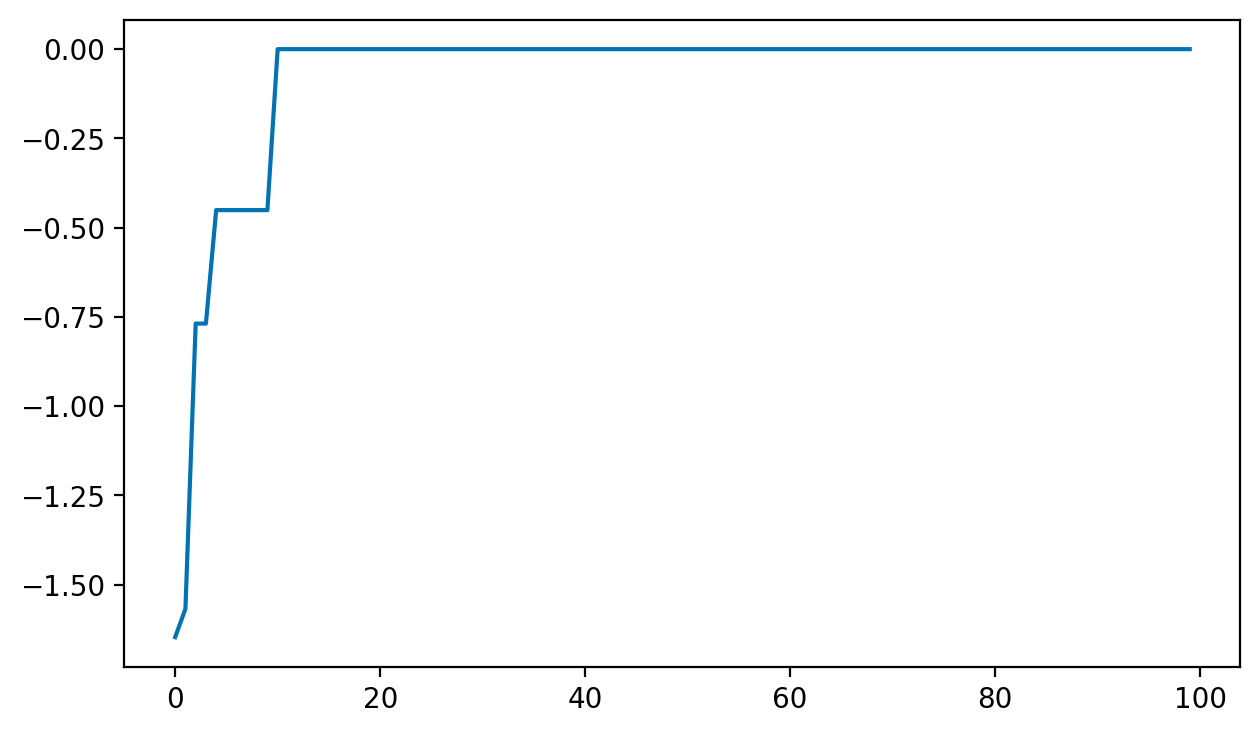

In [33]:
n_steps = 100
_, hist = eval_fn.test_run(key_run, n_steps, agent, bel_init, objective_fn, dim)
plt.plot(hist)

In [34]:
%%time
key = jax.random.PRNGKey(314)
keys = jax.random.split(key, 20)
runs = eval_fn.test_runs(keys, n_steps, agent, bel_init, objective_fn, dim, dim)
runs = jax.tree.map(np.array, runs)

runs = runs[1]

CPU times: user 17.2 s, sys: 1.78 s, total: 18.9 s
Wall time: 11 s


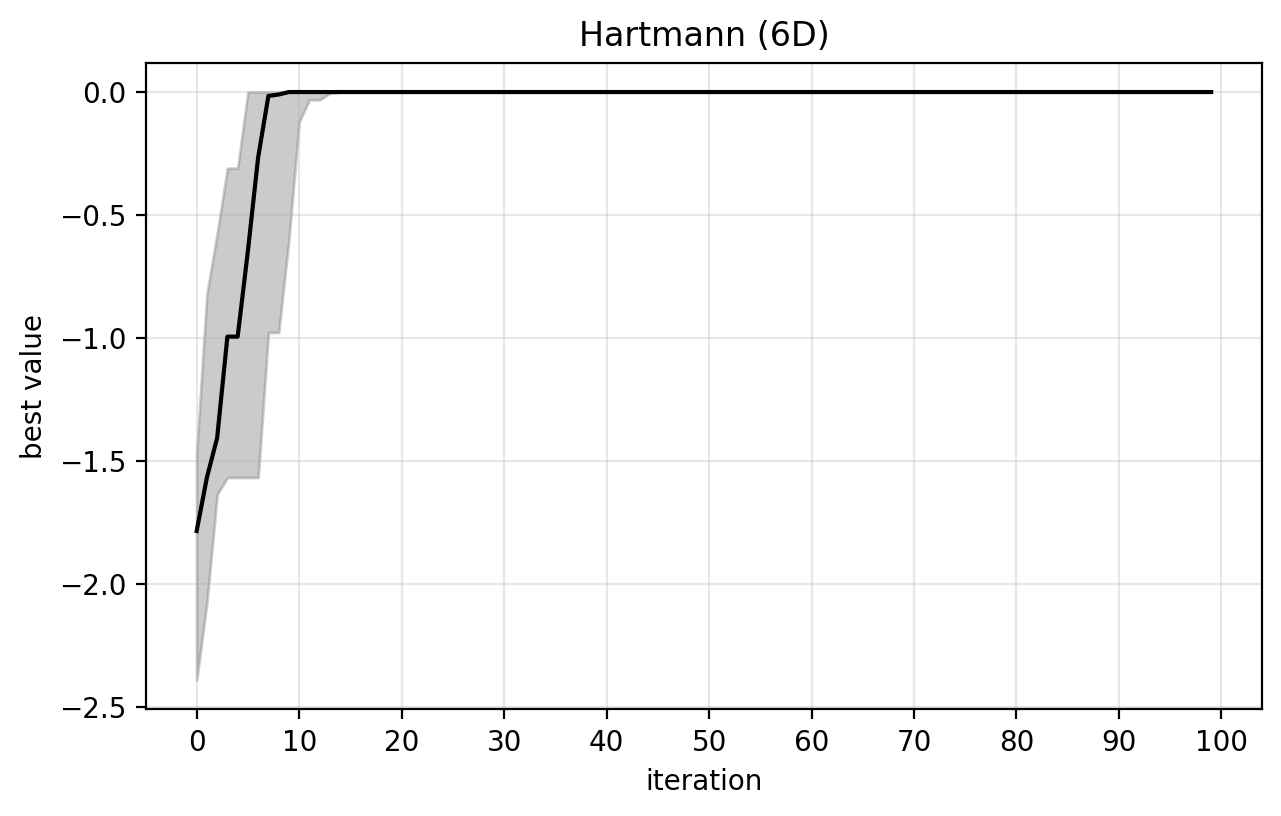

In [35]:
fig, ax = plt.subplots()
plot_hist(ax, runs)
plt.grid(alpha=0.3)
plt.title("Hartmann (6D)")
plt.ylabel("best value")
plt.xlabel("iteration")
plt.xticks(np.arange(0, 110, 10));

## Varying last-layer prior uncertainty

CPU times: user 115 ms, sys: 17.4 ms, total: 132 ms
Wall time: 24.3 s


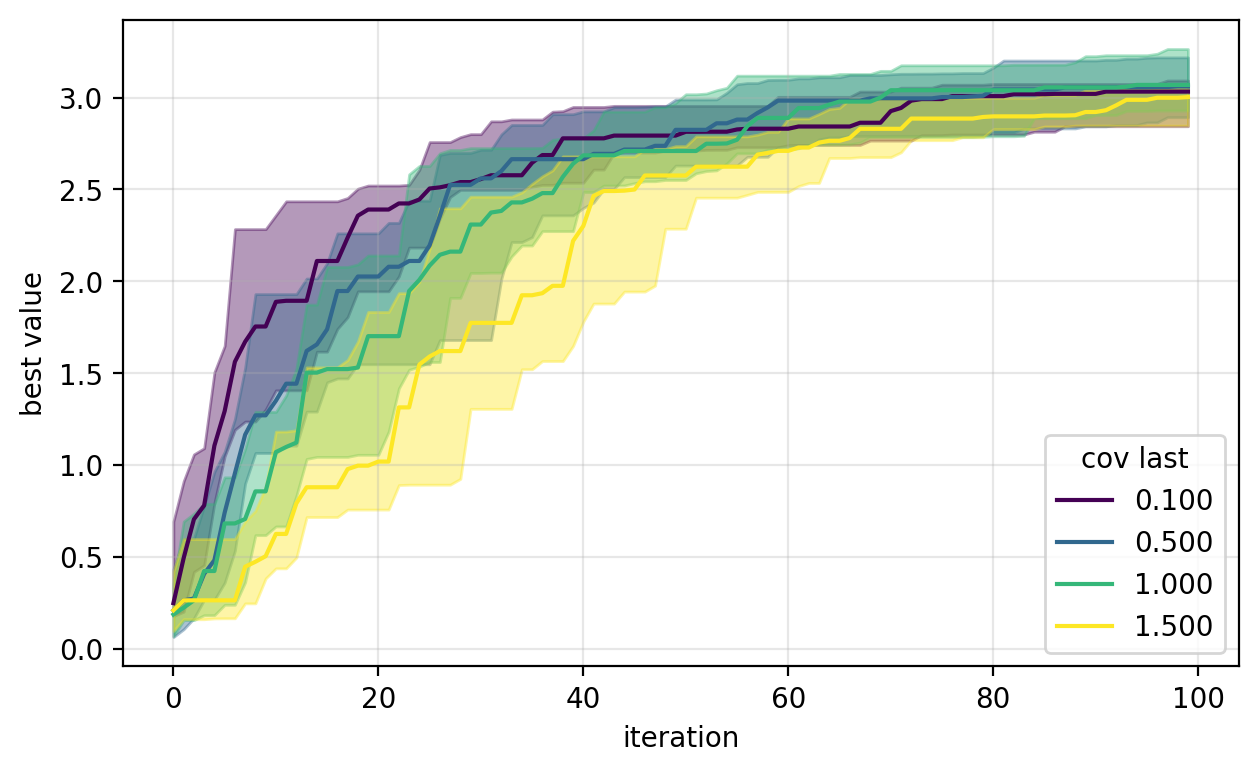

In [24]:
%%time
noise_terms = [0.1, 0.5, 1.0, 1.5]
colors = plt.cm.viridis(np.linspace(0, 1, len(noise_terms)))
fig, ax = plt.subplots()
diag = True
for color, noise in zip(colors, noise_terms):
    print(noise, end="\r")
    bel_init = agent.init_bel(
        params_init,
        cov_hidden=1e-3, # parameters do not vary much from their initial parameters
        cov_last=noise, # uncertainty in target
        low_rank_diag=False,
    )
    runs = eval_fn.test_runs(keys, n_steps, agent, bel_init, objective_fn, dim, dim)[1]
    runs = jax.tree.map(np.array, runs)
    plot_hist(ax, runs, color=color, label=format(noise, "0.3f"))
plt.ylabel("best value")
plt.xlabel("iteration")
plt.legend(title="cov last")
plt.grid(alpha=0.3)

## Varying hidden-layers uncertainty

CPU times: user 196 ms, sys: 88.7 ms, total: 285 ms
Wall time: 42.5 s


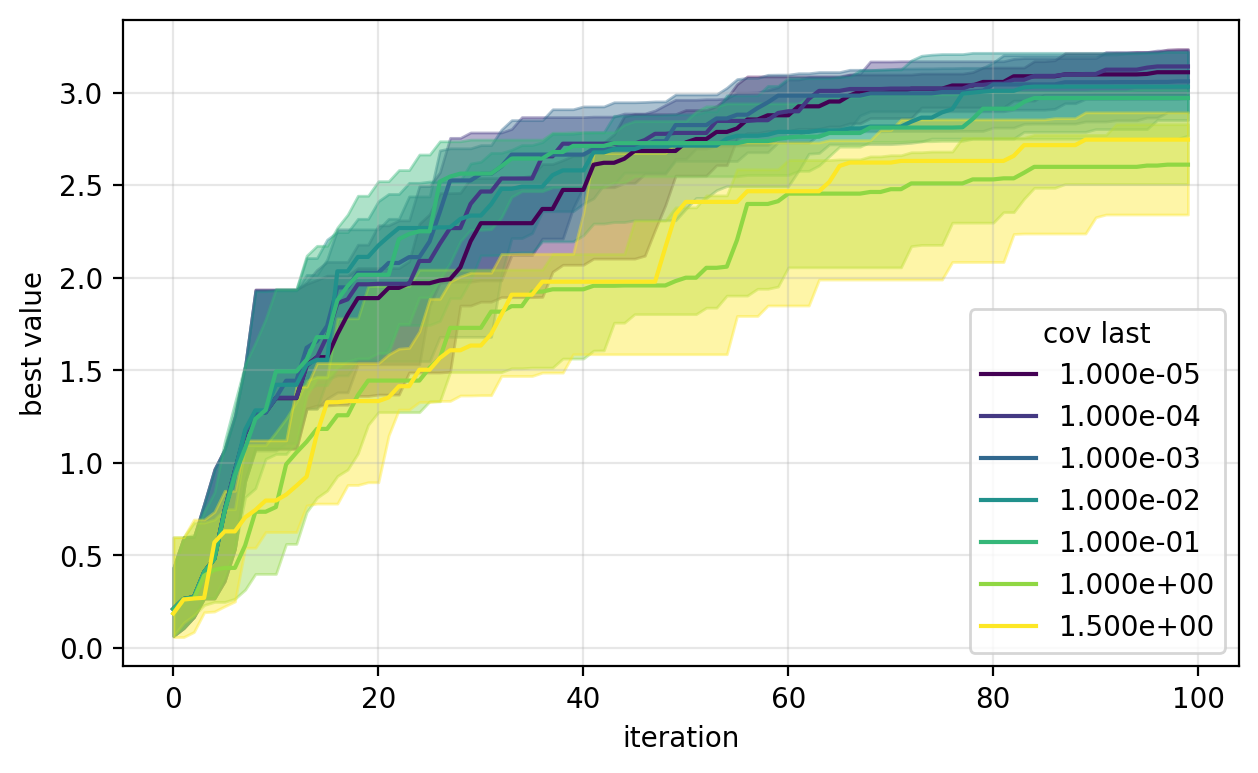

In [25]:
%%time
noise_terms = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 1.5]
colors = plt.cm.viridis(np.linspace(0, 1, len(noise_terms)))
fig, ax = plt.subplots()
diag = True
for color, noise in zip(colors, noise_terms):
    print(noise, end="\r")
    bel_init = agent.init_bel(
        params_init,
        cov_hidden=noise, # parameters do not vary much from their initial parameters
        cov_last=0.5, # uncertainty in target
        low_rank_diag=False,
    )
    runs = eval_fn.test_runs(keys, n_steps, agent, bel_init, objective_fn, dim, dim)[1]
    runs = jax.tree.map(np.array, runs)
    plot_hist(ax, runs, color=color, label=format(noise, "0.3e"))
plt.ylabel("best value")
plt.xlabel("iteration")
plt.legend(title="cov last")
plt.grid(alpha=0.3)